Here are all the module imports and global settings (such as plot styles and warning levels) for the whole notebook.

In [1]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import seaborn as sns

import copy
import cv2
import json
import math
import os
import sklearn
import torch
import warnings

from functools import partial
from graphviz import Digraph
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from IPython.display import Image
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from plotly.offline import plot
from pytorch_model_summary import summary
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from utils import make_meshgrid

pylab.rcParams['figure.figsize'] = 5, 5

plt.rc("font", size=15)

plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

warnings.filterwarnings("ignore")

# Table Of Contents:

* [**From fully-connected layers to convolution (actually cross-correlation)**](#fullyconn_to_conv)
* [**Even small kernels can extract meaningful pieces of information**](#small_kernels)
* [**Concept of channels**](#channels)
* [**Dealing with image size**](#img_size)    
    * [**Why is it important? LeNet: the "Hello World" of convolutional neural nets**](#lenet)
    * [**More complicated stuff**](#more_complicated)
        * [**Vgg architecture**](#vgg)
        * [**Even more complicated : Residual Net**](#resnet)
        
* [**Let's use a basic LeNet-type network on our subcellular data set**](#lenet_subcellular)
    * [**Sequence data as a 2-d image with one channel**](#seq_2d)
    * [**Sequence data as 1-d sequence with 20 channels**](#seq_1d)
    
* [**Interpretability of convolutional layers**](#interpretability)

# From fully-connected layers to convolution (actually cross-correlation) <a class="anchor" id="fullyconn_to_conv"></a>

We didn't leverage, so far, an important aspect of how our data (sequences) are structured. There is a notion of order and locality in our sequences. With the fully-connected Neural Nets that we were using before, we could have shuffled the sites, using the permutation for every sequence in the dataset, and we would have had the same results. Not only did we miss valuable information, but we also needed a lot of weights in our models.

Compared to that, convolutional layers are a great improvment. They allow us to incorporate information from neighboring sites to the information contained in each individual site. Convolutions also allow us to drastically reduce the number of weights needed to train. The weights defining the filters/kernels are shared over the whole sequence.

Convolutions can be better understood initialy when thinking about images, but they can easily be used and interpreted for sequences latter on. 

![Conv](images_cnn/correlation.svg)

$$
0\times0+1\times1+3\times2+4\times3=19,\\
1\times0+2\times1+4\times2+5\times3=25,\\
3\times0+4\times1+6\times2+7\times3=37,\\
4\times0+5\times1+7\times2+8\times3=43.
$$

Let $[\mathbf{H}]_{i, j}$ be the representation of the pixel that sits at position $i,j$ in the input image, $\Delta$ be the size of the kernel and $[\mathbf{V}]_{a, b} $ the kernel (or filter), a matrix of weights that you want to train. Additionally, let $u$ be a bias term. Then a single convolution from the convolution layer looks like

$$
[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}
$$

# Even small kernels can extract meaningful pieces of information <a class="anchor" id="small_kernels"></a>

Convolution allows you to grab some local signals from your image and use them to build a representation of this image. Those filters can be meaningful, enhancing horizontal/vertical lines, enhancing edges, etc. And they can be combined linearly to create new filters.

In [2]:
def corr2d(X, K):
    """Compute 2D cross-correlation."""
    h, w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))

    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = (X[i:i + h, j:j + w] * K).sum().astype(float)
    
    return Y

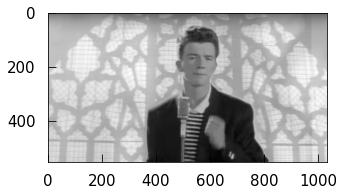

In [3]:
# Load image
img = cv2.imread('images_cnn/get_rick_rolled.png') 

# Gray-scaled version
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap='gray')
plt.show()

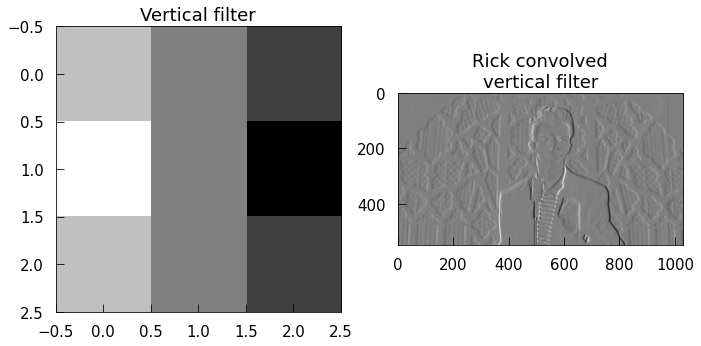

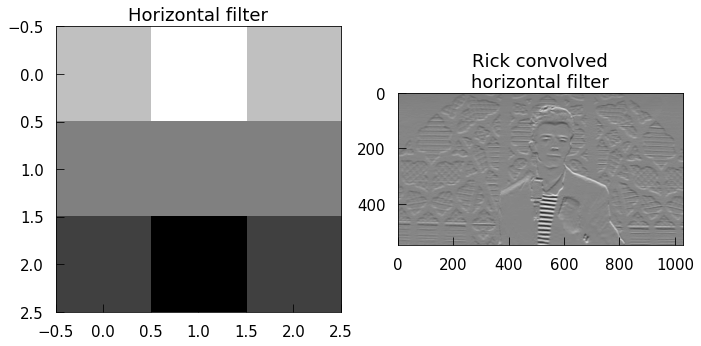

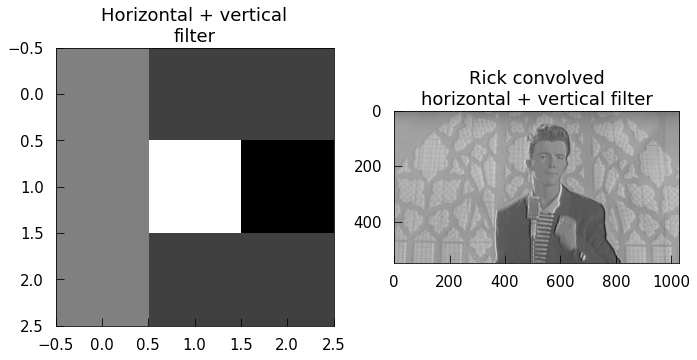

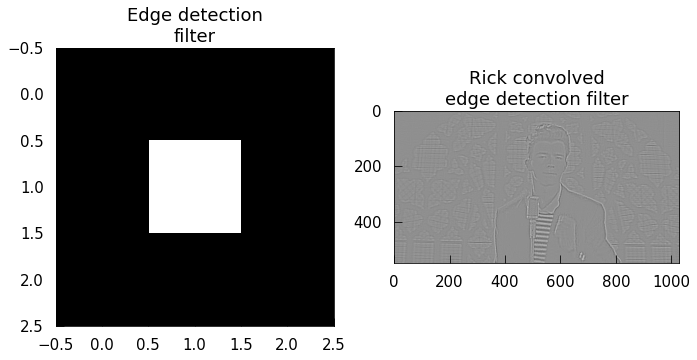

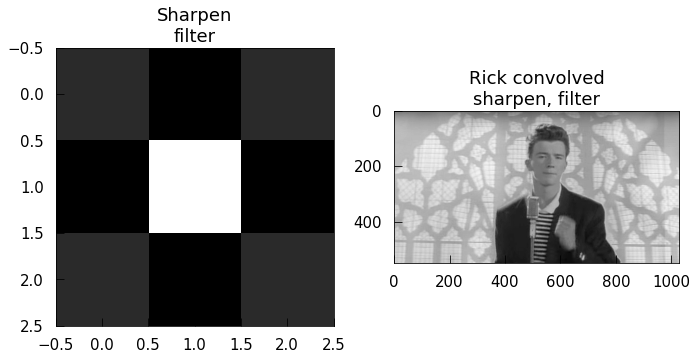

In [4]:
# Define filters by hand
K1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
K2 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
K3 = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
K4 = K3.T
K5 = K2 + K3

# Compute convolutions
Y1 = corr2d(gray, K1)
Y2 = corr2d(gray, K2)
Y3 = corr2d(gray, K3)
Y4 = corr2d(gray, K4)
Y5 = corr2d(gray, K5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(K3, cmap='gray')
ax[0].set_title('Vertical filter')

ax[1].imshow(Y3, cmap='gray')
ax[1].set_title('Rick convolved\nvertical filter')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(K4, cmap='gray')
ax[0].set_title('Horizontal filter')

ax[1].imshow(Y4, cmap='gray')
ax[1].set_title('Rick convolved\nhorizontal filter')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(K5, cmap='gray')
ax[0].set_title('Horizontal + vertical\nfilter')

ax[1].imshow(Y5, cmap='gray')
ax[1].set_title('Rick convolved\nhorizontal + vertical filter')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(K1, cmap='gray')
ax[0].set_title('Edge detection\nfilter')

ax[1].imshow(Y1, cmap='gray')
ax[1].set_title('Rick convolved\nedge detection filter')

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(K2, cmap='gray')
ax[0].set_title('Sharpen\nfilter')

ax[1].imshow(Y2, cmap='gray')
ax[1].set_title('Rick convolved\nsharpen, filter')

plt.tight_layout()
plt.show()

# Concept of channels <a class="anchor" id="channels"></a>

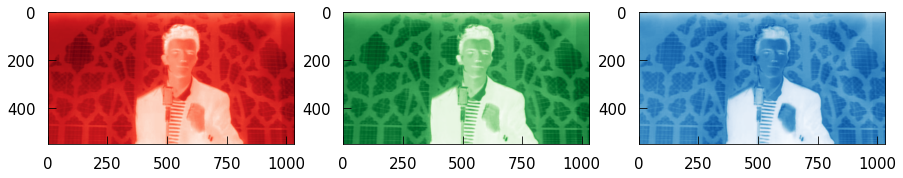

In [5]:
# Load image
img = cv2.imread('images_cnn/get_rick_rolled.png', 1) 

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Display channels
ax[0].imshow(img[:, :, 0], cmap='Reds')
ax[1].imshow(img[:, :, 1],cmap='Greens')
ax[2].imshow(img[:, :, 2],cmap='Blues')

plt.show()

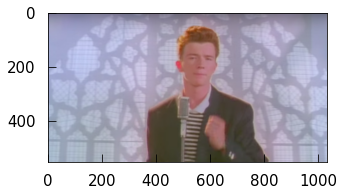

In [6]:
# Load image
img = cv2.imread('images_cnn/get_rick_rolled.png') 
colo = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(colo)
plt.show()

You can see the color channels (Red, Green, Blue) of the image as the result of passing the image through three different filters that select for a single color each. To retrieve the original image you can then just add the three filtered versions.

Convolutional layers do a similar thing. They run many convolutions, with different filters, in parallel and then add the many filtered images together. Each filter is defined by a set of weights, and it is those weights that are learned through your training. By learning the weights, you learn the filters.

![Conv_mutli](images_cnn/conv-multi-in.svg)

Using $c$ to represent the number of kernels that we are training we have, at the $d$-th layer, the representation

$$
[\mathsf{H}]_{i,j,d} = u +\sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a, b, c, d} [\mathsf{X}]_{i+a, j+b, c}.
$$

# Dealing with image size <a class="anchor" id="img_size"></a>

In the diagrams above it seems that convolution leads to a change in the image size.

![Conv_padded](images_cnn/conv-pad.svg)
![Conv_padded_odd](images_cnn/conv.gif)
![Conv_stride2](images_cnn/conv_stride_2.gif)

Reducing the size of the image (or sequence) as it passes through the network is actually very important for designing a model with reasonable size. Remember that whatever the network does in the initial layers, will have to be followed in the end by a dense layer that will take the flattened representation of our images and send it to a space with a dimension for each of the classes in our task (or a single dimension in case of regression). If you don't reduce the image size across the network, even a rather small 128-by-128 grid of pixels passing through 64 learned filters will lead to a dense layer with $64 \times 16384$ weights!

The size reduction is usually done using a form of "pooling", such as [Max-pooling](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling), but what pooling technique you want to use is up to you.

![Pooling](images_cnn/pooling.svg)

The potential changes in the dimension of your image (or sequence) need to be tracked because you need to design your last dense layer to be compatible with the dimensions of the representation in the second-to-last layer.

## Why is it important? LeNet: the "Hello World" of convolutional neural nets. <a class="anchor" id="lenet"></a>

The standard convolutional neural net architecture is [LeNet](https://en.wikipedia.org/wiki/LeNet). It looks like this: 

![Pooling](images_cnn/lenet.svg)

Note that in between convolution and pooling there is an activation step.

Here's my two cents: use an odd-sized filter and pad your image (sequence) with `int(sizekernel/2)`. In doing so, your image size changes only due to your pooling steps which is easily traceable: a pooling window of size 2 will divide your image size by 2, if your original dimensions are even, of course. It becomes then easy to calculate the input size for your dense layers.

## More complicated stuff <a class="anchor" id="more_complicated"></a>

### Vgg architecture <a class="anchor" id="vgg"></a>

![vgg-16](images_cnn/vgg16.png)

[Image source](https://neurohive.io/en/popular-networks/vgg16/)

In this network we have activation and batch normalization between each of the convolution layers, and dropout after the pooling. You can see blocks of neural nets within the larger network: this is why we were coding by blocks from the beginning of the workshop.

### Even more complicated : Residual Net <a class="anchor" id="resnet"></a>

![resnet-block](images_cnn/resnet-block.svg)
![resnet18](images_cnn/resnet18.svg)

# Let's use a basic LeNet-type network on our subcellular data set <a class="anchor" id="lenet_subcellular"></a>

In [7]:
data_path = 'Datasets/subcellular/'

X_train_subcell_ = np.load(os.path.join(data_path, 'reduced_train/X_train.npy'))
y_train_subcell_ = np.load(os.path.join(data_path, 'reduced_train/y_train.npy'))

X_val_subcell_ = np.load(os.path.join(data_path, 'reduced_val/X_val.npy'))
y_val_subcell_ = np.load(os.path.join(data_path, 'reduced_val/y_val.npy'))

train_i = np.arange(X_train_subcell_.shape[0])
np.random.seed(42)
np.random.shuffle(train_i)
X_train_subcell = np.array([X_train_subcell_[i] for i in train_i])
y_train_subcell = np.array([y_train_subcell_[i] for i in train_i])

train_i = np.arange(X_val_subcell_.shape[0])
np.random.seed(42)
np.random.shuffle(train_i)
X_val_subcell = np.array([X_val_subcell_[i] for i in train_i])
y_val_subcell = np.array([y_val_subcell_[i] for i in train_i])

X_train_subcell_ready = torch.FloatTensor(np.array([X_train_subcell[i] for i in range(X_train_subcell.shape[0])]))
X_val_subcell_ready = torch.FloatTensor(np.array([X_val_subcell[i] for i in range(X_val_subcell.shape[0])]))

X_train_subcell_ready = torch.FloatTensor(X_train_subcell)
X_val_subcell_ready = torch.FloatTensor(X_val_subcell)

y_train_subcell_ready = torch.LongTensor(y_train_subcell)
y_val_subcell_ready = torch.LongTensor(y_val_subcell)

## Sequence data as a 2-d image with one channel <a class="anchor" id="seq_2d"></a>

This is the type of data our model will take as an input, a tensor which is just a matrix with one channel.

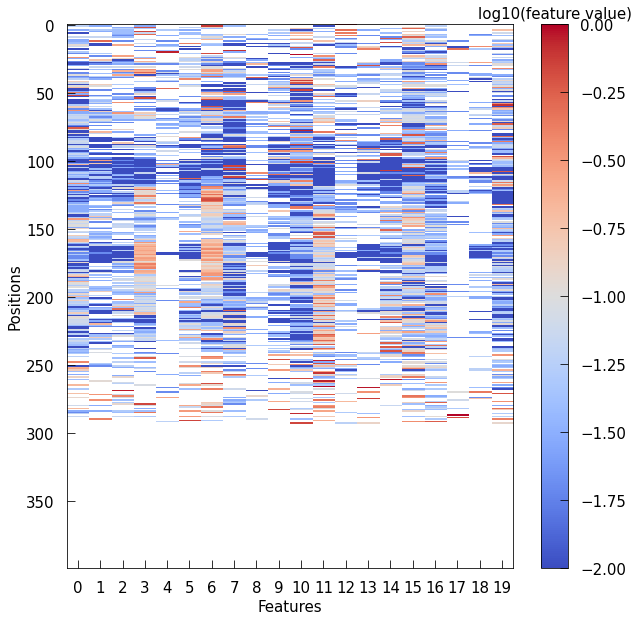

In [8]:
plt.figure(figsize = (10, 10))

plt.imshow(np.log10(X_train_subcell[1]), aspect='auto', cmap=plt.cm.coolwarm, interpolation='nearest')

cbar = plt.colorbar()
cbar.ax.set_title('log10(feature value)',fontsize=15)

plt.ylabel('Positions')
plt.xlabel('Features')

plt.xticks(np.arange(20))

plt.show()

In [9]:
X_train_subcell_ready.shape

torch.Size([2423, 400, 20])

In [10]:
X_train_subcell_ready.dtype

torch.float32

Here I didn't scale the different features, even though I probably should have. But scaling here is not a straightforward thing to do because of the format of the data. So let's do without scaling for now.

During the data preparation step we need to virtually add a dimension that codes for the channel.

In [11]:
def get_ready_2d_conv(X_train, y_train, X_val, y_val):
    device = torch.device("cuda")
    
    # Transfer all the data at once on the GPU : good in terms of I/O, not so good in terms of memory management
    device_X_train = X_train.view(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]).to(device)
    device_y_train = y_train.to(device)
    device_X_val = X_val.view(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2]).to(device)
    device_y_val = y_val.to(device)
    
    return device_X_train, device_y_train, device_X_val, device_y_val

In [12]:
class LeNet2d_block_drop_opt(torch.nn.Module):
    def __init__(self, in_channels, out_channels, relu_coeff, max_pool_kern_size, conv_kern_size):
        super(LeNet2d_block_drop_opt, self).__init__()
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.conv1 = torch.nn.Conv2d(in_channels, 
                                     out_channels, 
                                     kernel_size=self.conv_kern_size,
                                     stride=1,
                                     padding=int(self.conv_kern_size / 2))
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.pool = torch.nn.MaxPool2d(kernel_size=self.max_pool_kern_size)
        
    def forward(self,x):
        hidden = self.conv1(x)
        hidden = self.relu(hidden)
        maxpool = self.pool(hidden)
        return maxpool
        
class LeNet2d_deeper_drop_opt(torch.nn.Module):
    def __init__(self, LeNet2d_block_drop_opt, archi, number_classes, dro, relu_coeff, max_pool_kern_size, conv_kern_size, output_size):
        super(LeNet2d_deeper_drop_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = output_size
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x.view(x.shape[0], x.size(1) * x.size(2) * x.size(3)))
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(LeNet2d_block_drop_opt(archi[i][0], archi[i][1], self.relu_coeff, self.max_pool_kern_size, self.conv_kern_size))
        return torch.nn.Sequential(*layers)

We will go for two layers of convolutions. The first will have 32 kernels, and the second 64. All kernels will be of size of 4, and we will use a max. pooling mask of size 4-by-2. Feel free to experiment and change all of that.

In [13]:
def optimized_LeNet2d(params, dat):
    x_train_3, y_train_3, x_val_3, y_val_3 = dat
    
    epochs = 3000
    
    archi = ((1, 32), (32, 64))
    
    device = torch.device("cuda")
    
    model = LeNet2d_deeper_drop_opt(LeNet2d_block_drop_opt, archi, 10, params['dro'], params['relu_coeff'], (4, 2), 4, 64 * 25 * 5)
    model.to(device)
    
    w = compute_class_weight('balanced', np.unique(y_train_3.cpu()), np.array(y_train_3.cpu()))
    weights_classes = torch.tensor(w, dtype=torch.float32).to(device)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss = []
    keep_loss_val = []
    keep_score = []
    keep_score_val = []
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0,len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])

            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])
            
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train.cpu()).detach().numpy().tolist()), dim=1)
            f1_train = metrics.f1_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)].cpu(), 
                                        y_pred_train.cpu().detach().numpy().tolist(),
                                        average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val.cpu()).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].cpu(), 
                                          y_pred_val.cpu().detach().numpy().tolist(),
                                          average='weighted')
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        if epoch == 0:
            keep_best_score=keep_score_val[-1]
            keep_best_loss=keep_loss_val[-1]
        else:
            if keep_loss_val[-1] < keep_best_loss:
                keep_model = model
                keep_best_score = keep_score_val[-1]
                keep_best_loss = keep_loss_val[-1]
                
        if epoch % 1000 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
            
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
            print('Params', params)
        
        if (epoch > 1000) and (keep_loss_val[-1] > keep_loss_val[-2] + 5 * np.std(keep_loss_val[-100:-1])):
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b', label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(keep_best_score)
    
    return {'loss': -keep_best_score, 'status': STATUS_OK, 'Trained_Model': keep_model}

In [14]:
def getBestModelfromTrials(trials):
    # Get losses from valid trials
    valid_trial_list = [trial for trial in trials if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    
    # Best trial is the one with minimum lost
    index_having_minumum_loss = np.argmin(losses)
    best_trial_obj = valid_trial_list[index_having_minumum_loss]
    
    return best_trial_obj['result']['Trained_Model']

In [15]:
name = 'subcell_conv2d'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_conv2d_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_conv2d_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    model_best_conv2d_bigger = LeNet2d_deeper_drop_opt(LeNet2d_block_drop_opt, 
                                                       ((1, 32), (32, 64)), 
                                                       10, 
                                                       hp_best_conv2d_bigger['drop_out_rate'], 
                                                       hp_best_conv2d_bigger['relu_coefficient'], 
                                                       (4, 2), 4, 64 * 25 * 5)
    model_best_conv2d_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_conv2d_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_LeNet2d',
                  [{'dro':hp.uniform('drop_out_rate',0.01,0.2),
                    'relu_coeff':hp.uniform('relu_coefficient',0,0.5),
                    'wd':hp.uniform('weight_decay',0.0001,0.01),
                    'batch_size':hp.randint('mini_batch_size',64,64*5),
                    'l_r':hp.uniform('learning_rate',0.001,0.005)}])

    trials = Trials()
    hp_best_conv2d_bigger = fmin(partial(optimized_LeNet2d, dat=get_ready_2d_conv(X_train_subcell_ready, 
                                                                                  y_train_subcell_ready, 
                                                                                  X_val_subcell_ready, 
                                                                                  y_val_subcell_ready)), 
                                 space, 
                                 algo=tpe.suggest, 
                                 max_evals=20,
                                 trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_conv2d_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_conv2d_bigger))
        
    # Save optimized neural network
    model_best_conv2d_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_conv2d_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))
    

Best hyperparameters:
{'drop_out_rate': 0.1293498778145405, 'learning_rate': 0.004401407202051845, 'mini_batch_size': 314, 'optimized_LeNet2d': 0, 'relu_coefficient': 0.3172206259203457, 'weight_decay': 0.009737338150441208}


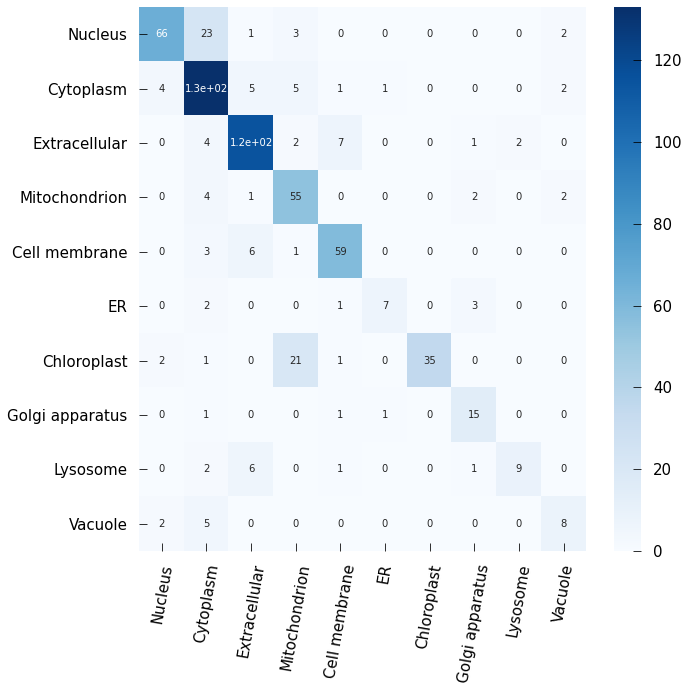

In [16]:
classes = ['Nucleus',
           'Cytoplasm',
           'Extracellular',
           'Mitochondrion',
           'Cell membrane',
           'ER',
           'Chloroplast',
           'Golgi apparatus',
           'Lysosome',
           'Vacuole']

dico_classes_subcell = {i:v for i, v in enumerate(classes)}

x_train_3, y_train_3, x_val_3, y_val_3 = get_ready_2d_conv(X_train_subcell_ready,
                                                           y_train_subcell_ready,
                                                           X_val_subcell_ready,
                                                           y_val_subcell_ready)

model_best_conv2d_bigger.eval()

device = torch.device("cuda")

y_pred = model_best_conv2d_bigger(x_val_3.to(device)).cpu()
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()

_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_3.cpu()), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.show()
plt.close()

In [17]:
print(summary(model_best_conv2d_bigger, x_train_3))

------------------------------------------------------------------------------------
               Layer (type)            Output Shape         Param #     Tr. Param #
   LeNet2d_block_drop_opt-1     [2423, 32, 100, 10]             544             544
   LeNet2d_block_drop_opt-2       [2423, 64, 25, 5]          32,832          32,832
                   Linear-3              [2423, 10]          80,010          80,010
                  Dropout-4              [2423, 10]               0               0
Total params: 113,386
Trainable params: 113,386
Non-trainable params: 0
------------------------------------------------------------------------------------


## Sequence data as 1-d sequence with 20 channels <a class="anchor" id="seq_1d"></a>

This time the input will be a tensor made of a 1-d matrix and 20 channels.

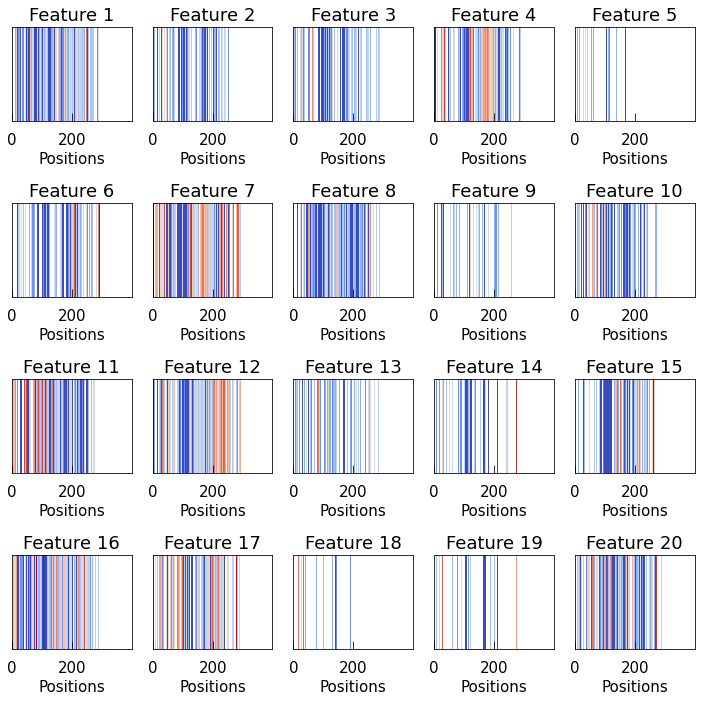

In [18]:
fig, ax = plt.subplots(4, 5, figsize=(10, 10))

k = 0
for i in range(4):
    for j in range(5):
        ax[i,j].imshow(np.log10(X_train_subcell[1][:,k].reshape(1, 400)),
                       aspect='auto',
                       cmap=plt.cm.coolwarm,
                       interpolation='nearest')
        k += 1

        ax[i,j].set_xlabel('Positions')
        ax[i,j].set_title('Feature ' + str(k))
        ax[i,j].set_yticks([])
        
plt.tight_layout()
plt.show()

In [19]:
def get_ready_1d_conv(X_train, y_train, X_val, y_val):
    device = torch.device("cuda")
    
    # Transfer all the data at once on the GPU : good in terms of I/O, not so good in terms of memory management
    device_X_train = X_train.view(X_train.shape[0], X_train.shape[1], X_train.shape[2]).permute(0, 2, 1).to(device)
    device_y_train = y_train.to(device)
    device_X_val = X_val.view(X_val.shape[0], X_val.shape[1], X_val.shape[2]).permute(0, 2, 1).to(device)
    device_y_val = y_val.to(device)
    
    return device_X_train, device_y_train, device_X_val, device_y_val

In [20]:
class LeNet1d_block_drop_opt(torch.nn.Module):
    def __init__(self, in_channels, out_channels, relu_coeff, max_pool_kern_size, conv_kern_size):
        super(LeNet1d_block_drop_opt, self).__init__()
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.conv1 = torch.nn.Conv1d(in_channels, 
                                     out_channels, 
                                     kernel_size=self.conv_kern_size,
                                     stride=1, 
                                     padding=int(self.conv_kern_size / 2))
        self.relu = torch.nn.LeakyReLU(self.relu_coeff)
        self.pool = torch.nn.MaxPool1d(kernel_size=self.max_pool_kern_size)
        
    def forward(self,x):
        hidden = self.conv1(x)
        hidden = self.relu(hidden)
        maxpool = self.pool(hidden)
        return maxpool
        
class LeNet1d_deeper_drop_opt(torch.nn.Module):
    def __init__(self, LeNet1d_block_drop_opt, archi, number_classes, dro, relu_coeff, max_pool_kern_size, conv_kern_size, output_size):
        super(LeNet1d_deeper_drop_opt, self).__init__()
        self.archi = archi
        self.dro = dro
        self.relu_coeff = relu_coeff
        self.max_pool_kern_size = max_pool_kern_size
        self.conv_kern_size = conv_kern_size
        self.number_classes = number_classes
        self.made_block = self._make_block(archi)
        self.output_size = output_size
        self.fc_out = torch.nn.Linear(self.output_size, self.number_classes)
        self.drop = torch.nn.Dropout(self.dro)
       
    def forward(self, x):
        x = self.made_block(x)
        output = self.fc_out(x.view(x.shape[0], x.size(1) * x.size(2)))
        output = self.drop(output)
        return output
    
    def _make_block(self, archi):
        layers = []
        for i in range(len(archi)):
            layers.append(LeNet1d_block_drop_opt(archi[i][0], archi[i][1], self.relu_coeff, self.max_pool_kern_size, self.conv_kern_size))
        return torch.nn.Sequential(*layers)

Once again, we will go for two layers of convolutions. The first will have 32 kernels, and the second 64. All convolutions with a kernel size of 4, and we will use a max. pooling mask of size 4. Feel free to experiment and change.

In [21]:
def optimized_LeNet1d(params, dat):
    x_train_3, y_train_3, x_val_3, y_val_3 = dat
    
    epochs = 3000

    archi = ((20, 32), (32, 64))
    
    device = torch.device("cuda")
    
    model = LeNet1d_deeper_drop_opt(LeNet1d_block_drop_opt, archi, 10, params['dro'], params['relu_coeff'], 4, 4, 64 * 25)
    model.to(device)
    
    w = compute_class_weight('balanced', np.unique(y_train_3.cpu()), np.array(y_train_3.cpu()))
    weights_classes = torch.tensor(w, dtype=torch.float32).to(device)
    print('weights_classes', weights_classes)
    
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_classes).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=params['l_r'], weight_decay=params['wd'])
    
    keep_loss = []
    keep_loss_val = []
    keep_score = []
    keep_score_val = []
    for epoch in range(epochs):
        losses = []
        f1s = []
        losses_val = []
        f1s_val = []
        model.train()
        for d in range(0, len(x_train_3), params['batch_size']):
            optimizer.zero_grad()

            # Forward pass
            output_train = model(x_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])

            # Compute Loss
            loss = loss_fn(output_train.squeeze(), y_train_3[d:min(d + params['batch_size'], len(x_train_3) - 1)])
            
            sm = torch.nn.Softmax(dim=1)
            _, y_pred_train = torch.max(torch.tensor(sm(output_train.cpu()).detach().numpy().tolist()), dim=1)
            f1_train = metrics.f1_score(y_train_3[d:min(d + params['batch_size'], len(x_train_3)-1)].cpu(), 
                                        y_pred_train.cpu().detach().numpy().tolist(),
                                        average='weighted')
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            losses.append(loss.item())
            f1s.append(f1_train.item())
            
        model.eval()
        with torch.no_grad():
            for d in range(0, len(x_val_3), params['batch_size']):
                output_val = model(x_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                sm = torch.nn.Softmax(dim=1)
                _, y_pred_val = torch.max(torch.tensor(sm(output_val.cpu()).detach().numpy().tolist()), dim=1)
                f1_val = metrics.f1_score(y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)].cpu(), 
                                          y_pred_val.cpu().detach().numpy().tolist(),
                                          average='weighted')
                loss_val = loss_fn(output_val.squeeze(), y_val_3[d:min(d + params['batch_size'], len(x_val_3) - 1)])
                losses_val.append(loss_val.item())
                f1s_val.append(f1_val.item())
            
        keep_loss.append(np.mean(losses))
        keep_loss_val.append(np.mean(losses_val))
        keep_score.append(np.mean(f1s))
        keep_score_val.append(np.mean(f1s_val))
        if epoch == 0:
            keep_best_score = keep_score_val[-1]
            keep_best_loss = keep_loss_val[-1]
        else:
            if keep_loss_val[-1] < keep_best_loss:
                keep_model = model
                keep_best_score = keep_score_val[-1]
                keep_best_loss = keep_loss_val[-1]
                
        if epoch % 1000 == 0:
            print('Epoch {}: train loss: {} validation loss: {}\ntrain f1: {} validation f1: {}'.format(epoch, 
                                                                                                        keep_loss[-1],
                                                                                                        keep_loss_val[-1],
                                                                                                        keep_score[-1],
                                                                                                        keep_score_val[-1]))
            
        if epoch == epochs - 1:
            print('Epoch {}: train loss: {} validation loss: {}train f1: {} validation f1: {}'.format(epoch, 
                                                                                                      keep_loss[-1],
                                                                                                      keep_loss_val[-1],
                                                                                                      keep_score[-1],
                                                                                                      keep_score_val[-1]))
            print('Params', params)

        if (epoch > 1000) and (keep_loss_val[-1] > keep_loss_val[-2] + 5 * np.std(keep_loss_val[-100:-1])):
            print('Params', params)
            break
            
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    
    ax[0].plot(np.arange(len(keep_loss)), keep_loss, 'r', label='training set')
    ax[0].plot(np.arange(len(keep_loss)), keep_loss_val, 'b', label='validation set')
    
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Cross entropy loss')
    ax[0].legend(loc='best')
    
    ax[1].plot(np.arange(len(keep_loss)), keep_score, 'r', label='training set')
    ax[1].plot(np.arange(len(keep_loss)), keep_score_val, 'b' ,label='validation set')
    
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 score')
    ax[1].legend(loc='best')
    
    plt.tight_layout()
    plt.show()
    
    print(keep_best_score)
    
    return {'loss': -keep_best_score, 'status': STATUS_OK, 'Trained_Model': keep_model}

In [22]:
name = 'subcell_conv1d'

try:    
    # Load optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json')) as f:
        hp_best_conv1d_bigger = json.loads(f.read())
        
    print("Best hyperparameters:")
    print(hp_best_conv1d_bigger)

    # Load optimized neural network
    device = torch.device("cuda")
    model_best_conv1d_bigger = LeNet1d_deeper_drop_opt(LeNet1d_block_drop_opt, 
                                                       ((20, 32), (32, 64)), 10, 
                                                       hp_best_conv1d_bigger['drop_out_rate'], 
                                                       hp_best_conv1d_bigger['relu_coefficient'],
                                                       4, 
                                                       4, 
                                                       64 * 25)
    model_best_conv1d_bigger.load_state_dict(torch.load(os.path.join('models', 'model_' + name + '.bin')))
    model_best_conv1d_bigger.to(device)
        
except FileNotFoundError:
    # Run hyperparameter optimization
    space = hp.choice('optimized_LeNet1d',
                      [{'dro':hp.uniform('drop_out_rate',0.01,0.2),
                        'relu_coeff':hp.uniform('relu_coefficient',0,0.5),
                        'wd':hp.uniform('weight_decay',0.0001,0.01),
                        'batch_size':hp.randint('mini_batch_size',64,64*5),
                        'l_r':hp.uniform('learning_rate',0.001,0.005)}])

    trials = Trials()
    hp_best_conv1d_bigger = fmin(partial(optimized_LeNet1d, dat=get_ready_1d_conv(X_train_subcell_ready,
                                                                                  y_train_subcell_ready,
                                                                                  X_val_subcell_ready,
                                                                                  y_val_subcell_ready)), 
                                 space, 
                                 algo=tpe.suggest, 
                                 max_evals=20,
                                 trials=trials)
    
    print("Best hyperparameters:")
    print(hp_best_conv1d_bigger)

    # Save optimized hyperparameters
    with open(os.path.join('models', 'hp_' + name + '.json'), 'w') as f:
        f.write(json.dumps(hp_best_conv1d_bigger))
        
    # Save optimized neural network
    model_best_conv1d_bigger = getBestModelfromTrials(trials)
    torch.save(model_best_conv1d_bigger.state_dict(), os.path.join('models', 'model_' + name + '.bin'))

Best hyperparameters:
{'drop_out_rate': 0.08019131849849591, 'learning_rate': 0.002337806323575286, 'mini_batch_size': 210, 'optimized_LeNet2d': 0, 'relu_coefficient': 0.3566239830819705, 'weight_decay': 0.00535594114685052}


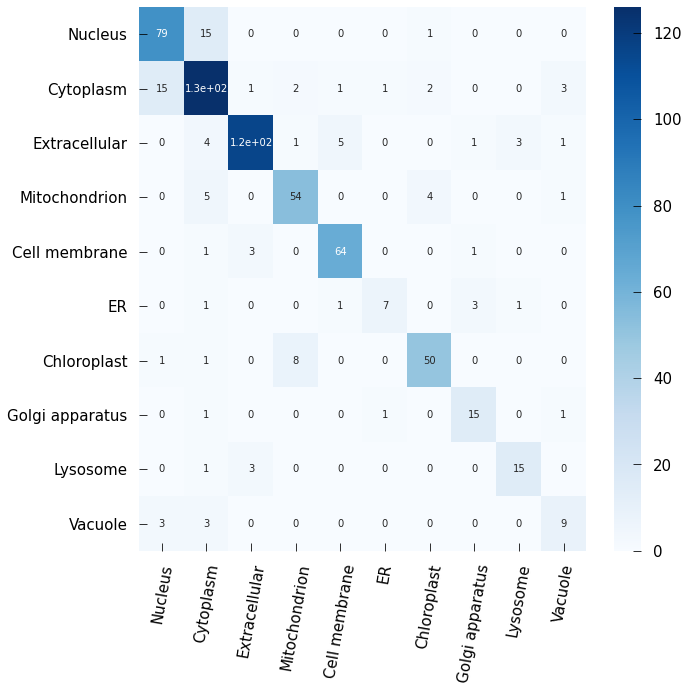

In [23]:
x_train_3, y_train_3, x_val_3, y_val_3 = get_ready_1d_conv(X_train_subcell_ready,
                                                           y_train_subcell_ready,
                                                           X_val_subcell_ready,
                                                           y_val_subcell_ready)

model_best_conv1d_bigger.eval()

device = torch.device("cuda")

y_pred = model_best_conv1d_bigger(x_val_3.to(device)).cpu()
sm = torch.nn.Softmax(dim=1)
y_pred = sm(y_pred).detach().numpy()

_, y_pred = torch.max(torch.tensor(y_pred), dim=1)

confusion_mc_c = confusion_matrix(np.array(y_val_3.cpu()), y_pred)
df_cm_c = pd.DataFrame(confusion_mc_c, index=np.arange(10), columns=np.arange(10))

plt.figure(figsize=(10, 10))

plt.ylabel('True label')
plt.xlabel('Predicted label')

ax = sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues)

ax.set_xticklabels(list(dico_classes_subcell.values()), rotation=80)
ax.set_yticklabels(list(dico_classes_subcell.values()), rotation=0)

plt.show()
plt.close()

This is by the way awesome. It such un upgrade compare to what we had before, using a simple feedforward.

In [24]:
print(summary(model_best_conv1d_bigger, x_train_3))

--------------------------------------------------------------------------------
               Layer (type)        Output Shape         Param #     Tr. Param #
   LeNet1d_block_drop_opt-1     [2423, 32, 100]           2,592           2,592
   LeNet1d_block_drop_opt-2      [2423, 64, 25]           8,256           8,256
                   Linear-3          [2423, 10]          16,010          16,010
                  Dropout-4          [2423, 10]               0               0
Total params: 26,858
Trainable params: 26,858
Non-trainable params: 0
--------------------------------------------------------------------------------


# Interpretability of convolutional layers <a class="anchor" id="interpretability"></a>

In [25]:
model = model_best_conv1d_bigger
keys = []
for name, value in model.named_parameters():
    keys.append(name)

In [26]:
keys

['made_block.0.conv1.weight',
 'made_block.0.conv1.bias',
 'made_block.1.conv1.weight',
 'made_block.1.conv1.bias',
 'fc_out.weight',
 'fc_out.bias']

In [27]:
outputs = []

def hook(module, input, output):
    outputs.append(output)

model.made_block[0].conv1.register_forward_hook(hook)
out = model(x_train_3[0:1, :, :])
out = model(x_train_3[10:11, :, :])

In graph that follows you can see where the signal on the first sequence seats in term of what the filters in the first layer deem as important. Each panel is one the 32 convolutions from one the 32 kernels that were learned during training. The horizontal axis of each plot represents the sequence position. So you can see in the places in the sequences (red color) that the learned kernel emphasizes.

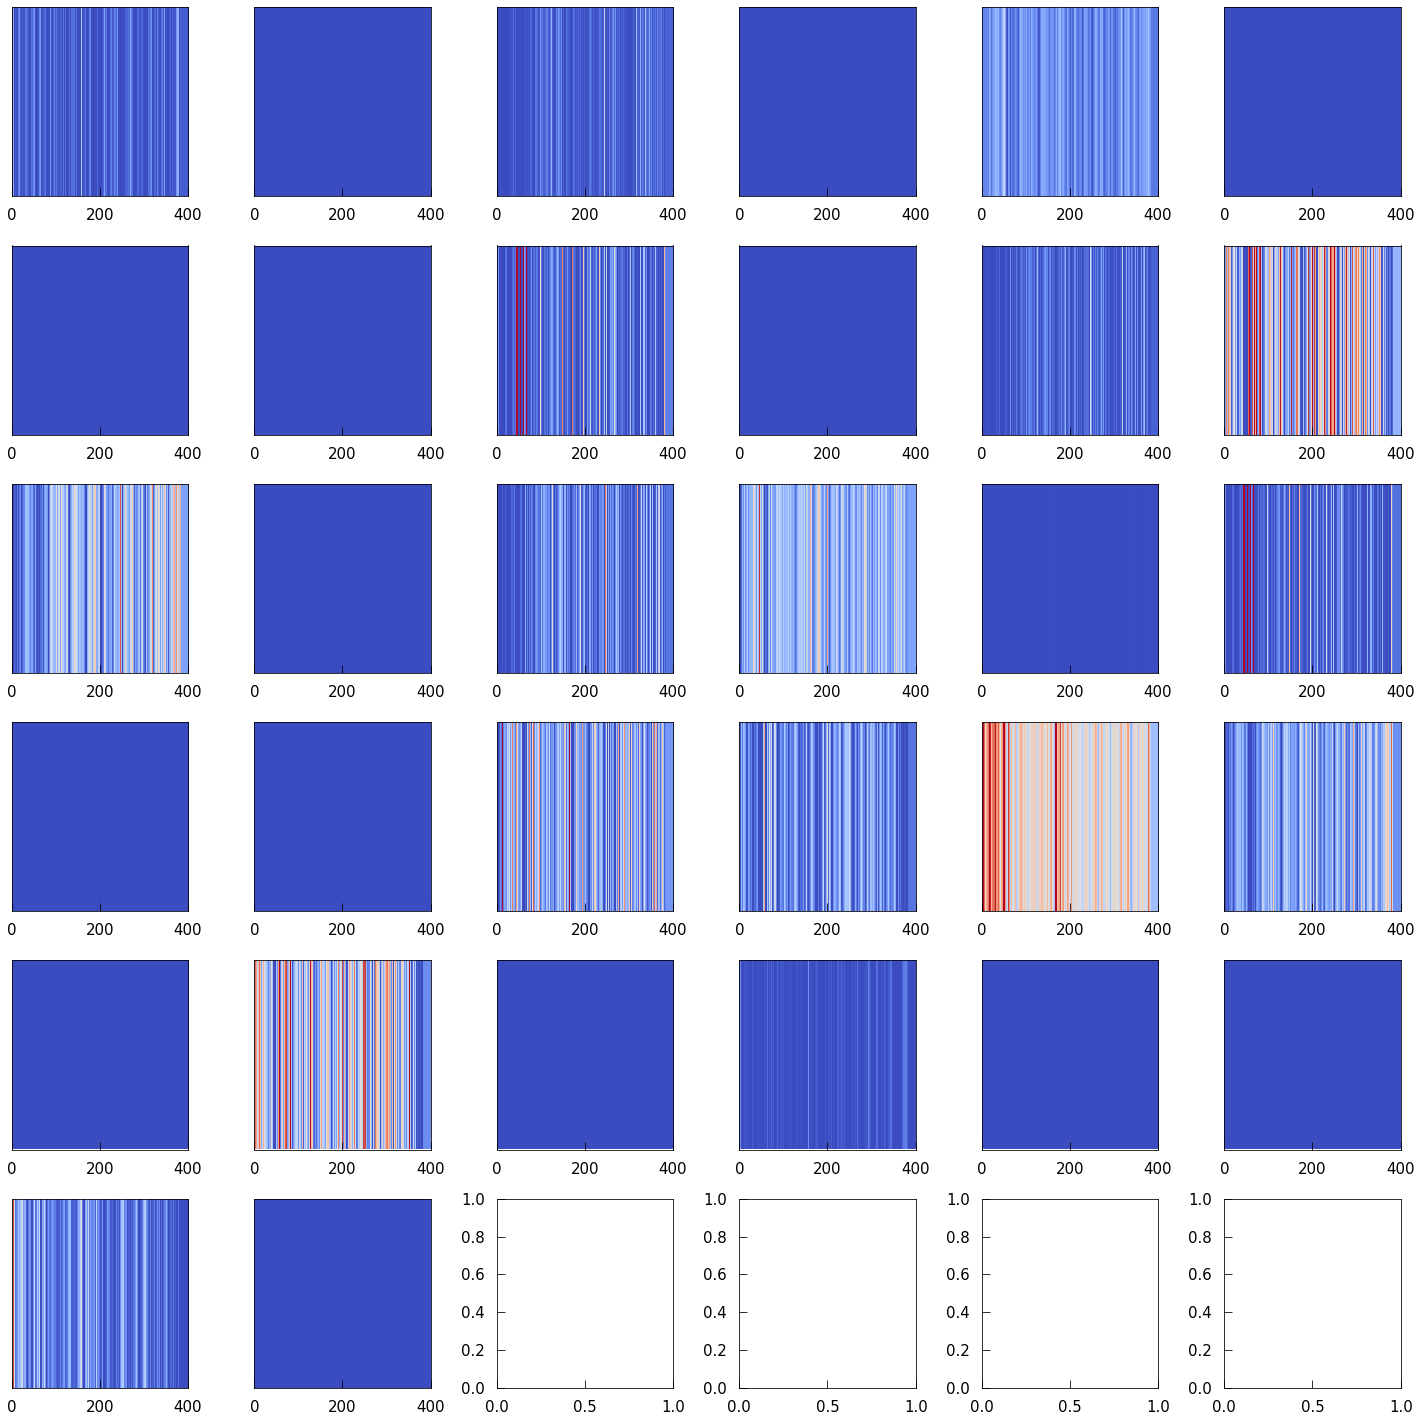

In [28]:
first_seq_first_layer = outputs[0][0].cpu().detach().numpy()

fig, ax = plt.subplots(6, 6, figsize=(20, 20))
k = 0
for i in range(6):
    for j in range(6):
        try:
            ax[i,j].imshow(first_seq_first_layer[k].reshape(1, 401),
                           aspect='auto',
                           cmap=plt.cm.coolwarm,
                           interpolation='nearest',
                           vmin=0,
                           vmax=1)
            ax[i,j].set_yticks([])
            k += 1
        except:
            None
            
plt.tight_layout()
plt.show()

Now we'll draw similar plots but for the 11th sequence.

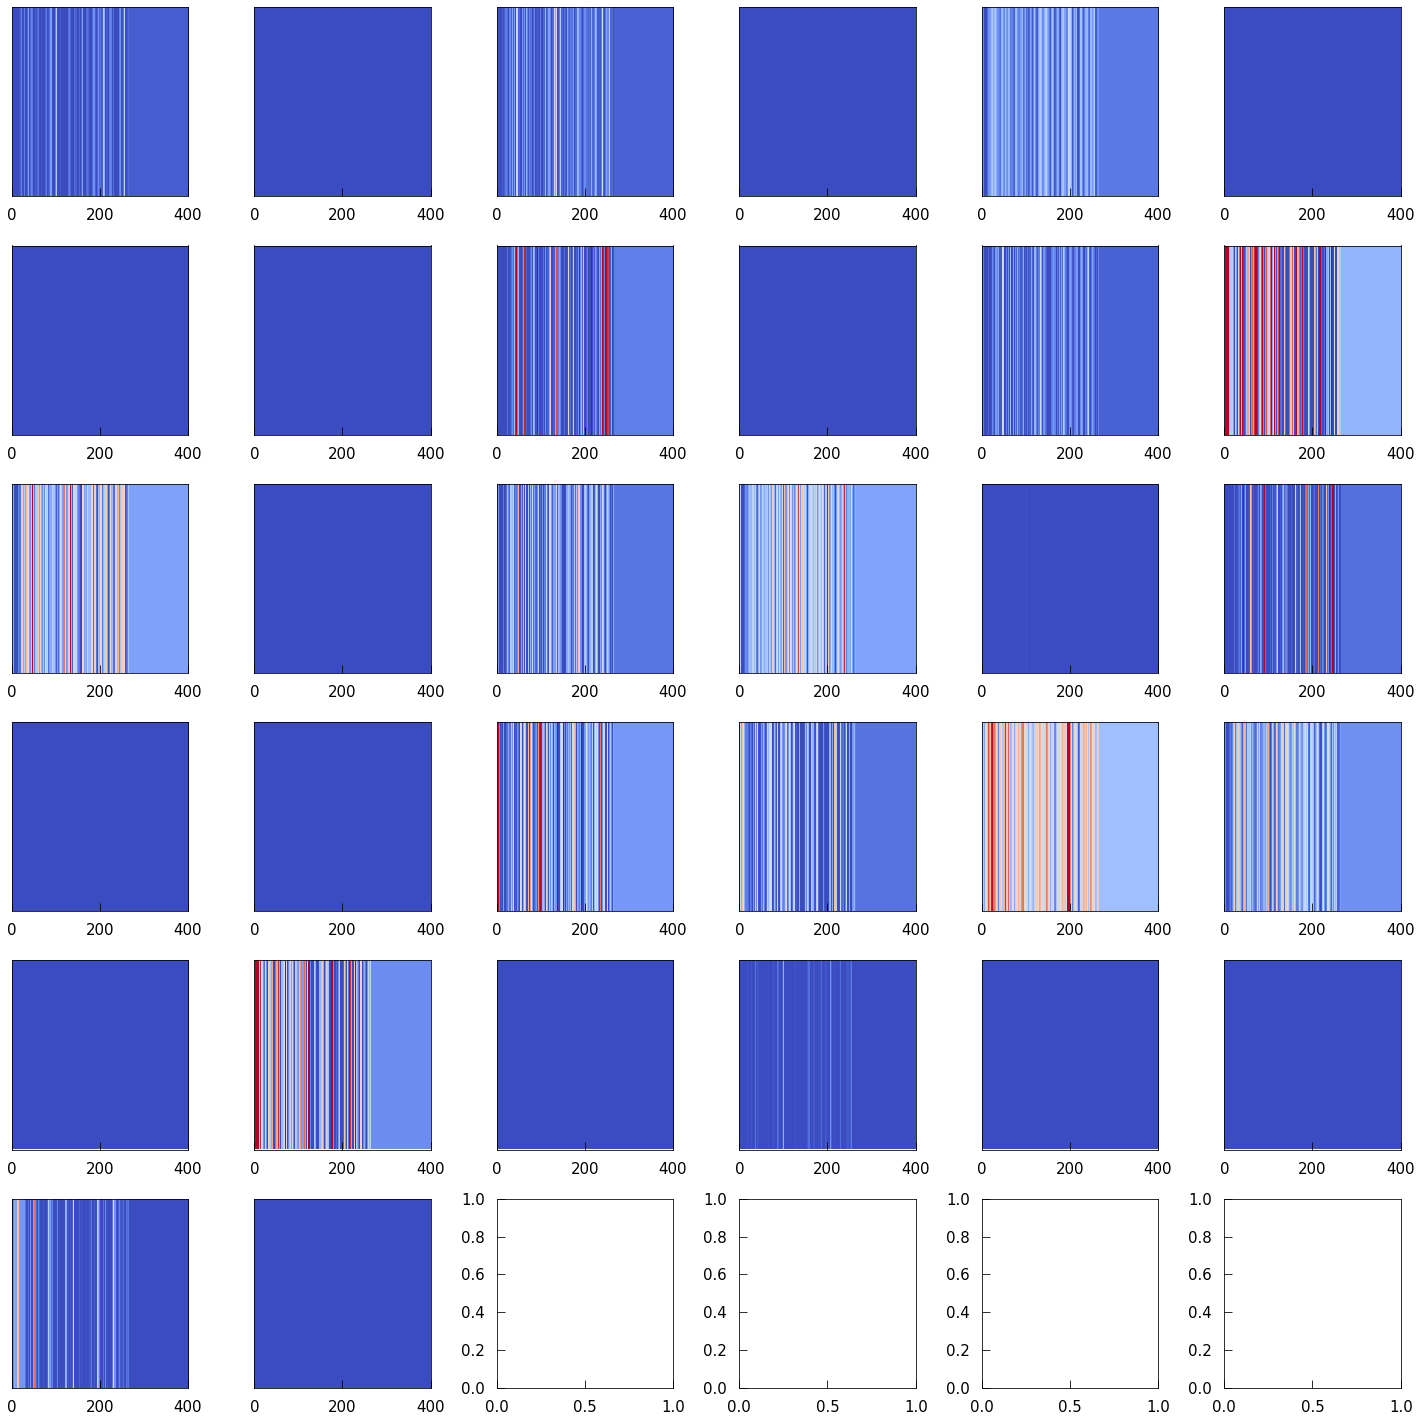

In [29]:
first_seq_first_layer = outputs[1][0].cpu().detach().numpy()

fig, ax = plt.subplots(6, 6, figsize=(20, 20))

k = 0 
for i in range(6):
    for j in range(6):
        try:
            ax[i, j].imshow(first_seq_first_layer[k].reshape(1, 401),
                            aspect='auto',
                            cmap=plt.cm.coolwarm,
                            interpolation='nearest',
                            vmin=0,
                            vmax=1)
            ax[i, j].set_yticks([])
            k += 1
        except:
            None
            
plt.tight_layout()
plt.show()

In principle, if you look at enough sequences you should be able to discern patterns the convolution filters emphasize. It is a tedious process, but possible nonetheless for the first layer. Doing so for the following layers becomes more complicated, but you could still get some valuable information there. Keep in mind that convolutional neural nets are hard to interpret, but they are not complete black boxes.